# Significant matches from a genome-wise TF motif scan

## Setup

### Imports

In [1]:
import polars as pl
import gzip
import numpy as np
import pyarrow.parquet as pq
import duckdb
import gzip
from pathlib import Path
import matplotlib.pyplot as plt

### Paths for input and output

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DB_ROOT = PROJECT_ROOT / 'db'
DATA_ROOT = Path('../igvf-pm')
MOTIFS_ROOT = DATA_ROOT / 'hlapp/motifs/matches'
MOTIFS_DB = DB_ROOT / 'motifs'

## Parquet database from per-chromosome TSV files

For performance reasons, we will not include _all_ motif matches in the database, but drop those below a chosen q-value cutoff, where the q-value is the one reported by FIMO.

In [3]:
# Function to write a partitioned parquet dataset from a list of file paths.
def write_database_of_matches(files, db_dir, 
                              column_rename={"sequence_name": "chrom",
                                             "p-value": "pvalue",
                                             "q-value": "qvalue",},
                              sep='\t',
                              qvalue_cutoff=0.1,
                              partition_cols=["chrom"]):
    # Loop over the files and write them to the database
    for file in files:
        print(f"Reading {file}")
        fopen = open if file.suffix == '.gz' else gzip.open
        df = (
            pl.scan_csv(fopen(file), separator=sep).
                filter(pl.col('q-value') <= qvalue_cutoff).
                rename(column_rename).
                collect()
        )

        # Write the dataset
        print(f"Writing to {db_dir}")
        pq.write_to_dataset(
            df.to_arrow(),
            root_path=db_dir,
            partition_cols=partition_cols,
            existing_data_behavior='overwrite_or_ignore',
        )

In [13]:
write_database_of_matches(MOTIFS_ROOT.glob('chr*.tsv.gz'), MOTIFS_DB)

Reading ../igvf-pm/hlapp/motifs/matches/chr15.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr12.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr16.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chrY.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr11.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr21.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr13.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr4.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr17.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr5.fimo.tsv.gz
Writing to /hpc/group/igvf/db/motifs
Reading ../igvf-pm/hlapp/motifs/matches/chr6.fimo.tsv

## Extract significant matches

Open the database we created, and see how many matches we have after whichever import cutoff on the q-values was applied.

In [11]:
motifs_db = duckdb.read_parquet(f"{MOTIFS_DB}/**/*.parquet", hive_partitioning=True)
motifs_db.count('pvalue')

┌───────────────┐
│ count(pvalue) │
│     int64     │
├───────────────┤
│      76907861 │
└───────────────┘

### Determining significance in light of multiple testing

The significance p-value of reported matches needs to be corrected for multiple testing, especially given the very large number of tests. The genome-wide scan was run over genomic regions in separate jobs for parallization. This means that the q-values for FDR-based multiple testing correction as originally reported, while valid within the region for which they were computed, are not valid for the whole genome scan.

One possibility is to use a Bonferroni correction. However, even for only the reported matches, this would result in a very conservative cutoff of 1e-10 (for FWER of 0.5), and the original scans already applied a p-value cutoff (of 0.0001), hence far less than all tests were reported. So the "real" Bonferroni correction should arguably be even more conservative.

Instead we try to leverage the q-values that were alredy computed. Specifically, we find a p-value cutoff that approximately corresponds to a desired q-value cutoff.

In [5]:
pvals = duckdb.sql('select pvalue from motifs_db where round(qvalue, 2) = 0.05').to_df()

The p-values sharing the same or nearly the same q-value cover several orders of magnitude:

Text(0.5, 1.0, 'Distribution of motif match p-values for q-value ~= 0.05')

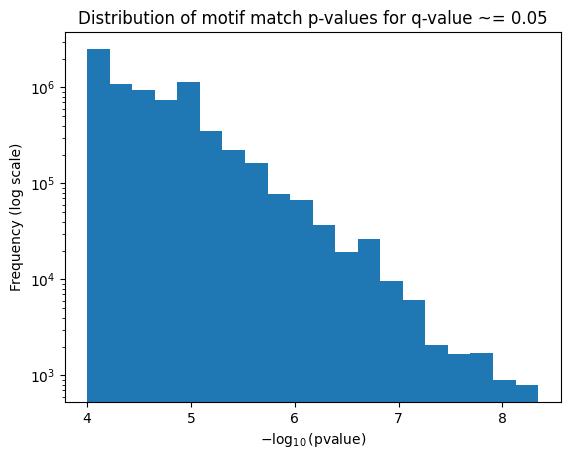

In [9]:
h = plt.hist(-np.log10(pvals['pvalue']), bins=20, log=True)
plt.xlabel('$-\log_{10}$(pvalue)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of motif match p-values for q-value ~= 0.05')

This is presumably because some regions had many (in fact, orders of magnitude) more weak or insignificant matches than others. (The number of tests could also differ markedly between regions, but seems less likely to cover orders of magnitude if region lengths were roughly the same.)

We will use the principle here that q-values must monotically decrease for p-values in descending order. I.e., if q-values were to be recomputed for the entire dataset, the p-value for any given q-value could not be higher than the lowest p-value found across all regions for a given q-value.

We find this p-value, and truncate it to the nearest power of 10:

In [10]:
p_min = 10**int(np.log10(pvals['pvalue'].min()))
p_min

1e-08

Then we can subset using this p-value. Note that the actual q-value for the chosen p-value, if recomputed over the entire scan, might be somewhat different from the cutoff we chose. I.e., we are assuming that the fraction and distribution of insignificant matches (and thus p-values) for the whole scan is similar to the one of the "worst" region. 

In [38]:
motifs_db_signif = duckdb.sql(f'select * from motifs_db where "pvalue" < {p_min}').to_arrow_table()
# write pyarrow table to parquet
pq.write_table(motifs_db_signif, f'{MOTIFS_DB}-signif.parquet')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))